In [1]:
%load_ext autoreload 
%autoreload 2
import pandas as pd
from tqdm.notebook import tqdm
import os

from mimic_helper_fs import get_ids_with_icd_codes, get_ids_with_kws
from mimic_helper_fs import get_coocurring_symptoms_codes, get_coocurring_symptoms_kws
from mimic_helper_fs import get_icd_code_long_title

from ipv_codes import NHAS_IPV_CODES, OREGON_IPV_CODES, USED_IPV_CODES, ICD10_IPV_CODES
from ipv_codes import KW_SETS, CODE_SETS

pd.set_option('max_rows', 500)
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', 80)


# Load data

In [2]:
mimic_iv_ed_data_path = '/home/t-dshanmugam/physionet.org/files/mimic-iv-ed/1.0/ed/'
mimic_iv_data_path = '/home/t-dshanmugam/physionet.org/files/mimiciv/1.0/'
hosp_data_path = mimic_iv_data_path + 'hosp/'

english_names = pd.read_csv(hosp_data_path + 'd_icd_diagnoses.csv.gz')
diagnoses = pd.read_csv(mimic_iv_ed_data_path + 'diagnosis.csv.gz')

old_len = len(diagnoses)
ed_diagnoses = pd.merge(diagnoses, 
                     english_names, 
                     how='inner', 
                     on=['icd_code', 'icd_version'], 
                     validate='many_to_one')
if  old_len != len(diagnoses):
    print("Warning: not all diagnoses are in ICD table: old len %i, new len %i (%2.3f%%)" % 
        (old_len, len(diagnoses), 100*len(diagnoses)/old_len))

In [226]:
diagnoses[diagnoses['icd_code'].str.startswith('T76')]

,subject_id,stay_id,seq_num,icd_code,icd_version,icd_title
471902,13042064,30058323,1,T7621XA,10,"Adult sexual abuse, suspected, initial encounter"
476256,16713769,30149023,1,T7621XA,10,"Adult sexual abuse, suspected, initial encounter"
504471,14312831,30738789,1,T7621XA,10,"Adult sexual abuse, suspected, initial encounter"
517592,16271028,31002336,1,T7621XA,10,"Adult sexual abuse, suspected, initial encounter"
530408,16627072,31275293,1,T7621XA,10,"Adult sexual abuse, suspected, initial encounter"
532899,13185237,31325492,1,T7621XA,10,"Adult sexual abuse, suspected, initial encounter"
546426,16896926,31607407,1,T7621XA,10,"Adult sexual abuse, suspected, initial encounter"
553740,11980948,31760752,1,T7621XA,10,"Adult sexual abuse, suspected, initial encounter"
559033,10076602,31868110,1,T7621XA,10,"Adult sexual abuse, suspected, initial encounter"
560158,13683311,31892402,1,T7621XA,10,"Adult sexual abuse, suspected, initial encounter"


# Prevalence of code sets

In [181]:
# TODO: understand relationship between stay_id and hadm_id
id_type = 'stay_id'
for ipv_code_name, ipv_codes in CODE_SETS:
    n_patients = len(get_ids_with_icd_codes(diagnoses, id_type, ipv_codes))
    p_y = n_patients/len(set(diagnoses[id_type]))
    print("# IPV patients using " +  ipv_code_name + " codes: ", n_patients, '\t p(y): ', p_y)

# IPV patients using NHAS Study codes:  85 	 p(y):  0.00018982536066818528
# IPV patients using Oregon Study codes:  1641 	 p(y):  0.003664746080664612
# IPV patients using US ED Study codes:  56 	 p(y):  0.000125061414087275
# IPV patients using ICD10 Codes codes:  49 	 p(y):  0.00010942873732636562


In [182]:
for kw_set in KW_SETS:
    n_patients = len(get_ids_with_kws(diagnoses, id_type, kw_set, descr_field='icd_title'))
    p_y = n_patients/len(set(diagnoses[id_type]))
    print("# IPV patients w/ kwds [" + ".".join(kw_set) + "]: ", n_patients, '\t p(y): ', p_y)

# IPV patients w/ kwds [adult physical abuse.adult abuse]:  40 	 p(y):  8.932958149091072e-05
# IPV patients w/ kwds [adult physical abuse.adult abuse.assault]:  2815 	 p(y):  0.006286569297422841
# IPV patients w/ kwds [adult physical abuse.adult abuse.maltreatment]:  68 	 p(y):  0.00015186028853454822
# IPV patients w/ kwds [partner]:  75 	 p(y):  0.0001674929652954576
# IPV patients w/ kwds [abuse]:  16838 	 p(y):  0.03760328732859886


# Prevalence of individual codes

In [183]:
from ipv_codes import IPV_RELATED_CODES, IPV_RELATED_KWS

prevalence_dicts = []
for kw in tqdm(IPV_RELATED_KWS):
    descr = "Contains: " + kw
    n_patients = len(get_ids_with_kws(diagnoses, id_type, [kw], descr_field='icd_title'))
    p_y = n_patients/len(set(diagnoses[id_type]))
    prevalence_dicts.append({'code': kw, 'long_title': descr, 'prevalence': p_y,
                             'count': n_patients})
for code in tqdm(IPV_RELATED_CODES):
    descr = get_icd_code_long_title(english_names, code)
    n_patients = len(get_ids_with_icd_codes(diagnoses, id_type, [code]))
    p_y = n_patients/len(set(diagnoses[id_type]))
    prevalence_dicts.append({'code': code, 'long_title': descr, 'prevalence': p_y,
                             'count': n_patients})

prevalence_df = pd.DataFrame(prevalence_dicts)
prevalence_df.sort_values('prevalence', ascending=False)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

,code,long_title,prevalence,count
2,abuse,Contains: abuse,0.037603,16838
0,assault,Contains: assault,0.006206,2779
15,E9688,Assault by other specified means,0.001726,773
7,E9689,Assault by unspecified means,0.001157,518
6,E966,Assault by cutting and piercing instrument,0.000288,129
5,partner,Contains: partner,0.000167,75
32,E9687,Assault by human bite,0.000147,66
35,E9600,Unarmed fight or brawl,0.000141,63
22,E9673,"Perpetrator of child and adult abuse, by spouse or partner",0.000125,56
8,T7621XA,"Adult sexual abuse, suspected, initial encounter",0.000103,46


# Triage data

In [184]:
triage = pd.read_csv(mimic_iv_ed_data_path + 'triage.csv.gz')
triage['chiefcomplaint'] = triage['chiefcomplaint'].astype(str)

# Summary statistics for triage table
print("# Stay IDs: ", len(set(triage['stay_id'])), "# Rows: ", len(triage))
print("# Unique Subjects: ", len(set(triage['subject_id'])), '\n')
triage_vars = ['heartrate', 'temperature', 'resprate', 'o2sat', 'sbp', 'dbp', 
               'pain', 'acuity', 'chiefcomplaint']
for triage_var in triage_vars:
    print("%  ", triage_var, "available (not nan): \t\t", triage[triage_var].count()/len(triage))

# Stay IDs:  448972 # Rows:  448972
# Unique Subjects:  216877 

%   heartrate available (not nan): 		 0.9595386794722165
%   temperature available (not nan): 		 0.9447159288329785
%   resprate available (not nan): 		 0.9519034594584963
%   o2sat available (not nan): 		 0.9512619940664451
%   sbp available (not nan): 		 0.9565674474132018
%   dbp available (not nan): 		 0.9546831428240514
%   pain available (not nan): 		 0.9330336858423243
%   acuity available (not nan): 		 0.9835557673975215
%   chiefcomplaint available (not nan): 		 1.0


In [185]:
# Prevalence of each keyword in chief complaints
for kw in IPV_RELATED_KWS:
    print(kw, ': ', len(triage[triage['chiefcomplaint'].str.contains(kw.upper())]))

assault :  629
adult physical abuse :  0
abuse :  85
maltreatment :  0
adult abuse :  0
partner :  0


# Patient demographics

In [186]:
patients = pd.read_csv(mimic_iv_data_path + 'core/patients.csv.gz')
admissions = pd.read_csv(mimic_iv_data_path + 'core/admissions.csv.gz')
edstays = pd.read_csv(mimic_iv_ed_data_path + 'edstays.csv.gz')
patient_diagnoses = pd.merge(diagnoses, admissions, on='subject_id', how='inner')

In [187]:
# Domains of 'ethnicity' and 'insurance'  features
ethnicities = set(admissions['ethnicity'])
insurances = set(admissions['insurance'])
print("Ethnicities: ", ethnicities)
print("Insurances: ", insurances)

Ethnicities:  {'HISPANIC/LATINO', 'BLACK/AFRICAN AMERICAN', 'ASIAN', 'OTHER', 'UNABLE TO OBTAIN', 'UNKNOWN', 'WHITE', 'AMERICAN INDIAN/ALASKA NATIVE'}
Insurances:  {'Other', 'Medicare', 'Medicaid'}


In [199]:
# Based on their documentation, seems like we have patient demographics for patients who were 
# checked into the hospital. This is maybe an issue if we want to look at patient features
# for patients who were only in the ED?
ids_in_both =  set(admissions['subject_id']).intersection(diagnoses['subject_id'])
print("# Patients in ed: ", len(set(diagnoses['subject_id'])))
print("# Patients in hosp: ", len(set(admissions['subject_id'])))
print("# Patients in both: ", len(ids_in_both))


# Patients in ed:  216467
# Patients in hosp:  256878
# Patients in both:  129365


In [193]:
# Select IDs with a specific code set
id_type = 'subject_id'
select_codes = US_ED_IPV_CODES
selected_ids = get_ids_with_icd_codes(patient_diagnoses, id_type, select_codes)
selected_rows = patient_diagnoses[patient_diagnoses[id_type].isin(selected_ids)]

In [194]:
# raw counts
feature_names = ['ethnicity', 'marital_status', 'insurance']
for feature_name in feature_names:
    selected_patients = selected_rows.groupby('subject_id').first().reset_index()
    print(selected_patients.groupby(feature_name)['subject_id'].count())
    print()

ethnicity
ASIAN                      1
BLACK/AFRICAN AMERICAN    11
HISPANIC/LATINO            6
OTHER                      4
WHITE                     16
Name: subject_id, dtype: int64

marital_status
DIVORCED     2
MARRIED      9
SINGLE      26
Name: subject_id, dtype: int64

insurance
Medicaid    11
Medicare     6
Other       21
Name: subject_id, dtype: int64



In [198]:
# relative prevalaence
feature_names = ['ethnicity', 'marital_status', 'insurance']
for feature_name in feature_names:
    all_patients = patient_diagnoses.groupby('subject_id').first().reset_index()
    feature_value_totals = all_patients.groupby(feature_name)['subject_id'].count()
    selected_patients = selected_rows.groupby('subject_id').first().reset_index()
    feature_value_counts = selected_patients.groupby(feature_name)['subject_id'].count()
    feature_value_prevalences = feature_value_counts/feature_value_totals
    feature_value_prevalences.fillna(0, inplace=True)
    print(feature_value_prevalences)
    print()

ethnicity
AMERICAN INDIAN/ALASKA NATIVE    0.000000
ASIAN                            0.000177
BLACK/AFRICAN AMERICAN           0.000565
HISPANIC/LATINO                  0.000791
OTHER                            0.000540
UNABLE TO OBTAIN                 0.000000
UNKNOWN                          0.000000
WHITE                            0.000191
Name: subject_id, dtype: float64

marital_status
DIVORCED    0.000233
MARRIED     0.000169
SINGLE      0.000504
WIDOWED     0.000000
Name: subject_id, dtype: float64

insurance
Medicaid    0.001004
Medicare    0.000154
Other       0.000264
Name: subject_id, dtype: float64



In [142]:
patient_diagnoses['stay_id'].count(), len(diagnoses), len(set(diagnoses['subject_id']))

(5926778, 949172, 216467)

# Are there ICD-10 codes in here?

In [204]:
triage = pd.read_csv(mimic_iv_ed_data_path + 'triage.csv.gz')
admissions = pd.read_csv(mimic_iv_data_path + 'core/admissions.csv.gz')

triage_admissions = pd.merge(triage, admissions, on='subject_id', how='inner')

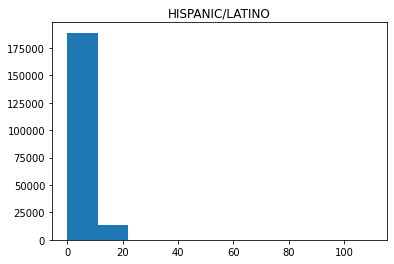

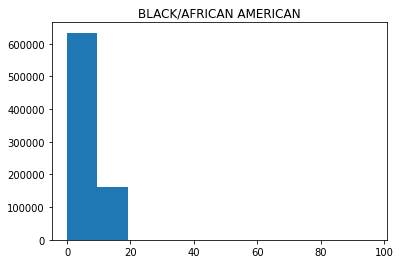

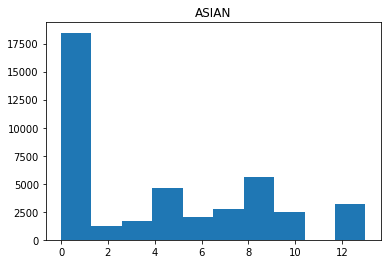

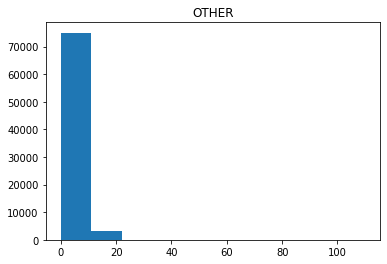

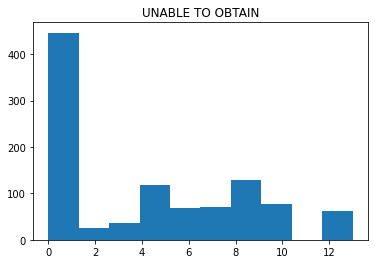

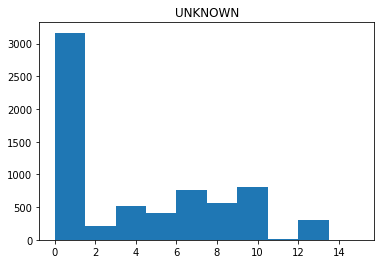

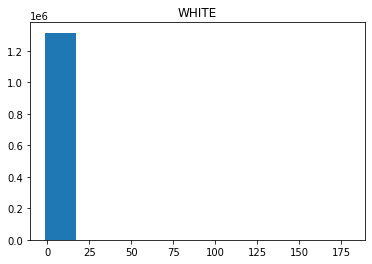

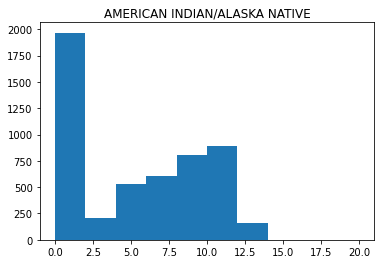

<Figure size 432x288 with 0 Axes>

In [209]:
ethnicities = list(set(triage_admissions['ethnicity']))
for ethnicity in ethnicities:
    plt.hist(triage_admissions[triage_admissions['ethnicity'] == ethnicity]['pain'])
    plt.title(ethnicity)
    plt.figure()

In [215]:
triage_admissions[(triage_admissions['ethnicity'] ==  'BLACK/AFRICAN AMERICAN') & (triage_admissions['pain'] > 20)]['chiefcomplaint']

942852                   Lower back pain
942853                   Lower back pain
942854                   Lower back pain
979002                               ___
979003                               ___
979004                               ___
979005                               ___
1132869           Abd pain, Constipation
1132870           Abd pain, Constipation
1178753            Altered mental status
1178754            Altered mental status
1178755            Altered mental status
1178756            Altered mental status
1178757            Altered mental status
1178758            Altered mental status
1178759            Altered mental status
1178760            Altered mental status
1178761            Altered mental status
1178762            Altered mental status
1178763            Altered mental status
1178764            Altered mental status
1178765            Altered mental status
1178766            Altered mental status
1178767            Altered mental status
1178768         